In [1]:
import pandas as pd
import scipy.stats
import pandas as pd
import nltk
import ast
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.stats import spearmanr
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from statsmodels.stats.outliers_influence import variance_inflation_factor

### 1st Data 

#### no removal

In [2]:
df = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data1/reddit_scores.csv')

In [3]:
spearman_comments = scipy.stats.spearmanr(df['memorability_score'], df['comments'])
spearman_upvotes = scipy.stats.spearmanr(df['memorability_score'], df['upvotes'])

print('Memorability ~ Comments:',
      '\n', f'Spearman rho: {spearman_comments[0].round(3)}',
      '\n', f'p value: {spearman_comments[1].round(5)}')

print('Memorability ~ upvotes:',
      '\n', f'Spearman rho: {spearman_upvotes[0].round(3)}',
      '\n', f'p value: {spearman_upvotes[1].round(5)}')

Memorability ~ Comments: 
 Spearman rho: 0.183 
 p value: 3e-05
Memorability ~ upvotes: 
 Spearman rho: 0.103 
 p value: 0.02089


#### "outlier" removal

In [4]:
# Concatenate
raw = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data1/reddit_scores.csv')

In [5]:
# Calculate Q1, Q3, and IQR for 'upvotes'
Q1_upvotes = raw['upvotes'].quantile(0.25)
Q3_upvotes = raw['upvotes'].quantile(0.75)
IQR_upvotes = Q3_upvotes - Q1_upvotes

# Calculate Q1, Q3, and IQR for 'comments'
Q1_comments = raw['comments'].quantile(0.25)
Q3_comments = raw['comments'].quantile(0.75)
IQR_comments = Q3_comments - Q1_comments

# Determine outliers' thresholds for 'upvotes'
lower_thresh_upvotes = Q1_upvotes - 1.5 * IQR_upvotes
upper_thresh_upvotes = Q3_upvotes + 1.5 * IQR_upvotes

# Determine outliers' thresholds for 'comments'
lower_thresh_comments = Q1_comments - 1.5 * IQR_comments
upper_thresh_comments = Q3_comments + 1.5 * IQR_comments

# outlier indices
outlier_indices = raw[(raw['upvotes'] < lower_thresh_upvotes) | (raw['upvotes'] > upper_thresh_upvotes) |
                      (raw['comments'] < lower_thresh_comments) | (raw['comments'] > upper_thresh_comments)].index

# Filter out outliers for both 'upvotes' and 'comments'
df = raw.drop(outlier_indices).reset_index(drop=True)

In [6]:
# Ensure the `date_posted` is in datetime format
df['date_posted'] = pd.to_datetime(df['date_posted'])
# Convert `date_posted` into a numeric feature (e.g., days since the earliest post)
df['days_since_start'] = (df['date_posted'] - df['date_posted'].min()).dt.total_seconds() / (60 * 60 * 24)  # Convert to days

In [7]:
spearman_comments = scipy.stats.spearmanr(df['memorability_score'], df['comments'])
spearman_upvotes = scipy.stats.spearmanr(df['memorability_score'], df['upvotes'])

print('Memorability ~ Comments:',
      '\n', f'Spearman rho: {spearman_comments[0].round(3)}',
      '\n', f'p value: {spearman_comments[1].round(5)}')

print('Memorability ~ upvotes:',
      '\n', f'Spearman rho: {spearman_upvotes[0].round(3)}',
      '\n', f'p value: {spearman_upvotes[1].round(5)}')

Memorability ~ Comments: 
 Spearman rho: 0.157 
 p value: 0.0014
Memorability ~ upvotes: 
 Spearman rho: 0.059 
 p value: 0.23262


In [8]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to parse the JSON strings
def parse_json(json_str):
    try:
        return ast.literal_eval(json_str)
    except ValueError as e:
        print(f"Error parsing JSON: {e}")

# Apply the function to each entry in the 'top_comments' column
df.loc[:, 'top_comments'] = df['top_comments'].apply(parse_json)

df['sentiment_scores'] = df['top_comments'].apply(
    lambda comments: [sia.polarity_scores(comment['comment_body'])['compound'] for comment in comments if 'comment_body' in comment]
)

df.loc[:,'average_sentiment'] = df['sentiment_scores'].apply(lambda scores: sum(scores) / len(scores) if scores else 0)

correlation, p_value = spearmanr(df['memorability_score'], df['average_sentiment'])

print(f"Spearman rho: {correlation.round(3)}")
print(f"p value: {p_value.round(5)}")

Spearman rho: -0.176
p value: 0.00032


### 2nd Data

#### no removal

In [9]:
df = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data2/reddit_scores.csv')

In [10]:
spearman_comments = scipy.stats.spearmanr(df['memorability_score'], df['comments'])
spearman_upvotes = scipy.stats.spearmanr(df['memorability_score'], df['upvotes'])

print('Memorability ~ Comments:',
      '\n', f'Spearman rho: {spearman_comments[0].round(3)}',
      '\n', f'p value: {spearman_comments[1].round(5)}')

print('Memorability ~ upvotes:',
      '\n', f'Spearman rho: {spearman_upvotes[0].round(3)}',
      '\n', f'p value: {spearman_upvotes[1].round(5)}')

Memorability ~ Comments: 
 Spearman rho: 0.135 
 p value: 0.00971
Memorability ~ upvotes: 
 Spearman rho: 0.133 
 p value: 0.01054


#### "outlier" removal

In [11]:
# Concatenate
raw = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data2/reddit_scores.csv')

In [12]:
# Calculate Q1, Q3, and IQR for 'upvotes'
Q1_upvotes = raw['upvotes'].quantile(0.25)
Q3_upvotes = raw['upvotes'].quantile(0.75)
IQR_upvotes = Q3_upvotes - Q1_upvotes

# Calculate Q1, Q3, and IQR for 'comments'
Q1_comments = raw['comments'].quantile(0.25)
Q3_comments = raw['comments'].quantile(0.75)
IQR_comments = Q3_comments - Q1_comments

# Determine outliers' thresholds for 'upvotes'
lower_thresh_upvotes = Q1_upvotes - 1.5 * IQR_upvotes
upper_thresh_upvotes = Q3_upvotes + 1.5 * IQR_upvotes

# Determine outliers' thresholds for 'comments'
lower_thresh_comments = Q1_comments - 1.5 * IQR_comments
upper_thresh_comments = Q3_comments + 1.5 * IQR_comments

# outlier indices
outlier_indices = raw[(raw['upvotes'] < lower_thresh_upvotes) | (raw['upvotes'] > upper_thresh_upvotes) |
                      (raw['comments'] < lower_thresh_comments) | (raw['comments'] > upper_thresh_comments)].index

# Filter out outliers for both 'upvotes' and 'comments'
df = raw.drop(outlier_indices).reset_index(drop=True)

In [13]:
spearman_comments = scipy.stats.spearmanr(df['memorability_score'], df['comments'])
spearman_upvotes = scipy.stats.spearmanr(df['memorability_score'], df['upvotes'])

print('Memorability ~ Comments:',
      '\n', f'Spearman rho: {spearman_comments[0].round(3)}',
      '\n', f'p value: {spearman_comments[1].round(5)}')

print('Memorability ~ upvotes:',
      '\n', f'Spearman rho: {spearman_upvotes[0].round(3)}',
      '\n', f'p value: {spearman_upvotes[1].round(5)}')

Memorability ~ Comments: 
 Spearman rho: 0.132 
 p value: 0.02457
Memorability ~ upvotes: 
 Spearman rho: 0.138 
 p value: 0.01875


In [14]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to parse the JSON strings
def parse_json(json_str):
    try:
        return ast.literal_eval(json_str)
    except ValueError as e:
        print(f"Error parsing JSON: {e}")

# Apply the function to each entry in the 'top_comments' column
df.loc[:, 'top_comments'] = df['top_comments'].apply(parse_json)

df['sentiment_scores'] = df['top_comments'].apply(
    lambda comments: [sia.polarity_scores(comment['comment_body'])['compound'] for comment in comments if 'comment_body' in comment]
)

df.loc[:,'average_sentiment'] = df['sentiment_scores'].apply(lambda scores: sum(scores) / len(scores) if scores else 0)

correlation, p_value = spearmanr(df['memorability_score'], df['average_sentiment'])

print(f"Spearman rho: {correlation.round(3)}")
print(f"p value: {p_value.round(5)}")

Spearman rho: -0.18
p value: 0.00214


### 3rd Data

#### no removal

In [15]:
df = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data3/reddit_scores.csv')

In [16]:
spearman_comments = scipy.stats.spearmanr(df['memorability_score'], df['comments'])
spearman_upvotes = scipy.stats.spearmanr(df['memorability_score'], df['upvotes'])

print('Memorability ~ Comments:',
      '\n', f'Spearman rho: {spearman_comments[0].round(3)}',
      '\n', f'p value: {spearman_comments[1].round(5)}')

print('Memorability ~ upvotes:',
      '\n', f'Spearman rho: {spearman_upvotes[0].round(3)}',
      '\n', f'p value: {spearman_upvotes[1].round(5)}')

Memorability ~ Comments: 
 Spearman rho: 0.329 
 p value: 0.0
Memorability ~ upvotes: 
 Spearman rho: 0.03 
 p value: 0.56116


#### "outlier" removal

In [17]:
# Concatenate
raw = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data3/reddit_scores.csv')

In [18]:
# Calculate Q1, Q3, and IQR for 'upvotes'
Q1_upvotes = raw['upvotes'].quantile(0.25)
Q3_upvotes = raw['upvotes'].quantile(0.75)
IQR_upvotes = Q3_upvotes - Q1_upvotes

# Calculate Q1, Q3, and IQR for 'comments'
Q1_comments = raw['comments'].quantile(0.25)
Q3_comments = raw['comments'].quantile(0.75)
IQR_comments = Q3_comments - Q1_comments

# Determine outliers' thresholds for 'upvotes'
lower_thresh_upvotes = Q1_upvotes - 1.5 * IQR_upvotes
upper_thresh_upvotes = Q3_upvotes + 1.5 * IQR_upvotes

# Determine outliers' thresholds for 'comments'
lower_thresh_comments = Q1_comments - 1.5 * IQR_comments
upper_thresh_comments = Q3_comments + 1.5 * IQR_comments

# outlier indices
outlier_indices = raw[(raw['upvotes'] < lower_thresh_upvotes) | (raw['upvotes'] > upper_thresh_upvotes) |
                      (raw['comments'] < lower_thresh_comments) | (raw['comments'] > upper_thresh_comments)].index

# Filter out outliers for both 'upvotes' and 'comments'
df = raw.drop(outlier_indices).reset_index(drop=True)

In [19]:
spearman_comments = scipy.stats.spearmanr(df['memorability_score'], df['comments'])
spearman_upvotes = scipy.stats.spearmanr(df['memorability_score'], df['upvotes'])

print('Memorability ~ Comments:',
      '\n', f'Spearman rho: {spearman_comments[0].round(3)}',
      '\n', f'p value: {spearman_comments[1].round(5)}')

print('Memorability ~ upvotes:',
      '\n', f'Spearman rho: {spearman_upvotes[0].round(3)}',
      '\n', f'p value: {spearman_upvotes[1].round(5)}')

Memorability ~ Comments: 
 Spearman rho: 0.234 
 p value: 5e-05
Memorability ~ upvotes: 
 Spearman rho: -0.193 
 p value: 0.00083


In [20]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to parse the JSON strings
def parse_json(json_str):
    try:
        return ast.literal_eval(json_str)
    except ValueError as e:
        print(f"Error parsing JSON: {e}")

# Apply the function to each entry in the 'top_comments' column
df.loc[:, 'top_comments'] = df['top_comments'].apply(parse_json)

df['sentiment_scores'] = df['top_comments'].apply(
    lambda comments: [sia.polarity_scores(comment['comment_body'])['compound'] for comment in comments if 'comment_body' in comment]
)

df.loc[:,'average_sentiment'] = df['sentiment_scores'].apply(lambda scores: sum(scores) / len(scores) if scores else 0)

correlation, p_value = spearmanr(df['memorability_score'], df['average_sentiment'])

print(f"Spearman rho: {correlation.round(3)}")
print(f"p value: {p_value.round(5)}")

Spearman rho: -0.28
p value: 0.0


## Concat data

#### no removal

In [84]:
data1 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data1/reddit_scores.csv')
data2 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data2/reddit_scores.csv')
data3 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data3/reddit_scores.csv')

df = pd.concat([data1, data2, data3], ignore_index=True)

In [85]:
spearman_comments = scipy.stats.spearmanr(df['memorability_score'], df['comments'])
spearman_upvotes = scipy.stats.spearmanr(df['memorability_score'], df['upvotes'])

print('Memorability ~ Comments:',
      '\n', f'Spearman rho: {spearman_comments[0].round(3)}',
      '\n', f'p value: {spearman_comments[1].round(5)}')

print('Memorability ~ upvotes:',
      '\n', f'Spearman rho: {spearman_upvotes[0].round(3)}',
      '\n', f'p value: {spearman_upvotes[1].round(5)}')

Memorability ~ Comments: 
 Spearman rho: 0.23 
 p value: 0.0
Memorability ~ upvotes: 
 Spearman rho: 0.087 
 p value: 0.00222


In [86]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to parse the JSON strings
def parse_json(json_str):
    try:
        return ast.literal_eval(json_str)
    except ValueError as e:
        print(f"Error parsing JSON: {e}")

# Apply the function to each entry in the 'top_comments' column
df.loc[:, 'top_comments'] = df['top_comments'].apply(parse_json)

df['sentiment_scores'] = df['top_comments'].apply(
    lambda comments: [sia.polarity_scores(comment['comment_body'])['compound'] for comment in comments if 'comment_body' in comment]
)

df.loc[:,'average_sentiment'] = df['sentiment_scores'].apply(lambda scores: sum(scores) / len(scores) if scores else 0)
spearman_sentiments = spearmanr(df['memorability_score'], df['average_sentiment'])

print(f"Spearman rho: {spearman_sentiments[0].round(3)}")
print(f"p value: {spearman_sentiments[1].round(8)}")

Spearman rho: -0.214
p value: 0.0


#### "outlier" removal

In [23]:
raw = pd.concat([data1, data2, data3], ignore_index=True)

In [24]:
# Calculate Q1, Q3, and IQR for 'upvotes'
Q1_upvotes = raw['upvotes'].quantile(0.25)
Q3_upvotes = raw['upvotes'].quantile(0.75)
IQR_upvotes = Q3_upvotes - Q1_upvotes

# Calculate Q1, Q3, and IQR for 'comments'
Q1_comments = raw['comments'].quantile(0.25)
Q3_comments = raw['comments'].quantile(0.75)
IQR_comments = Q3_comments - Q1_comments

# Determine outliers' thresholds for 'upvotes'
lower_thresh_upvotes = Q1_upvotes - 1.5 * IQR_upvotes
upper_thresh_upvotes = Q3_upvotes + 1.5 * IQR_upvotes

# Determine outliers' thresholds for 'comments'
lower_thresh_comments = Q1_comments - 1.5 * IQR_comments
upper_thresh_comments = Q3_comments + 1.5 * IQR_comments

# outlier indices
outlier_indices = raw[(raw['upvotes'] < lower_thresh_upvotes) | (raw['upvotes'] > upper_thresh_upvotes) |
                      (raw['comments'] < lower_thresh_comments) | (raw['comments'] > upper_thresh_comments)].index

# Filter out outliers for both 'upvotes' and 'comments'
df = raw.drop(outlier_indices).reset_index(drop=True)

In [25]:
spearman_comments = scipy.stats.spearmanr(df['memorability_score'], df['comments'])
spearman_upvotes = scipy.stats.spearmanr(df['memorability_score'], df['upvotes'])

print('Memorability ~ Comments:',
      '\n', f'Spearman rho: {spearman_comments[0].round(3)}',
      '\n', f'p value: {spearman_comments[1].round(5)}')

print('Memorability ~ upvotes:',
      '\n', f'Spearman rho: {spearman_upvotes[0].round(3)}',
      '\n', f'p value: {spearman_upvotes[1].round(5)}')

Memorability ~ Comments: 
 Spearman rho: 0.203 
 p value: 0.0
Memorability ~ upvotes: 
 Spearman rho: -0.004 
 p value: 0.90241


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score

X = df['memorability_score'].values.reshape(-1, 1)
y = df['comments'].values

X_const = sm.add_constant(X).reshape(-1, 2) 

# Fit the Negative Binomial model
nb_model = sm.GLM(y, X_const, family=sm.families.NegativeBinomial(alpha=0.27)).fit(cov_type='HC3')
print(nb_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  997
Model:                            GLM   Df Residuals:                      995
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3202.7
Date:                Mon, 21 Jul 2025   Deviance:                       965.55
Time:                        16:30:59   Pearson chi2:                 1.39e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06514
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5384      0.116     13.293      0.0

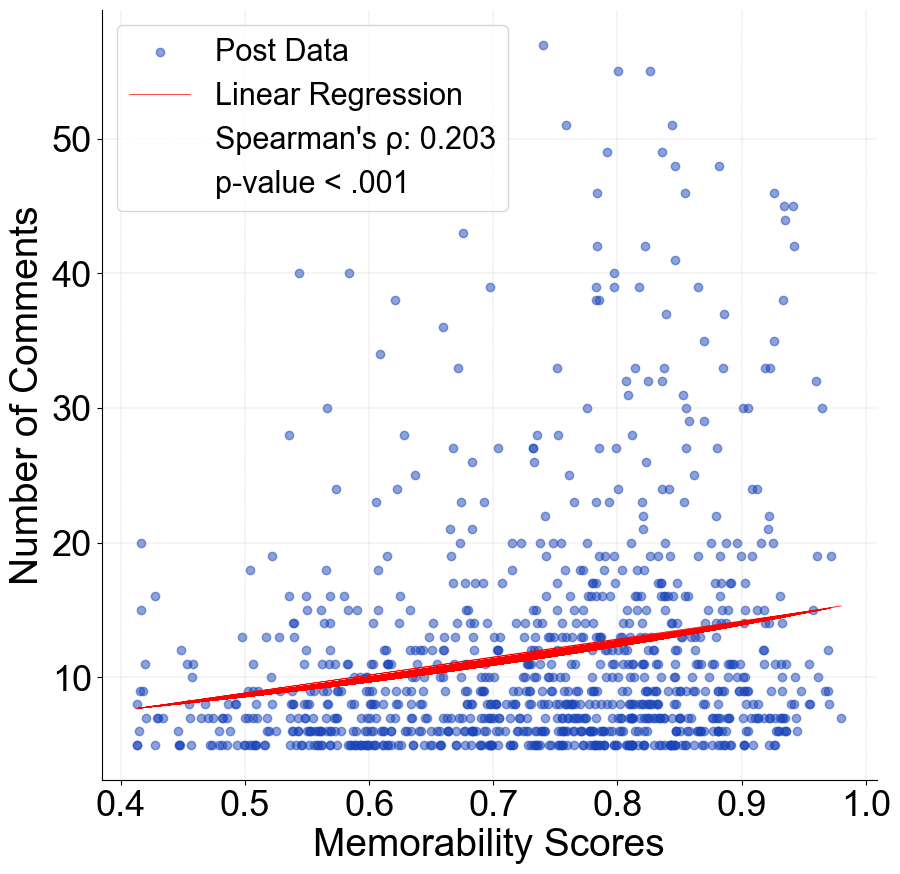

In [27]:
# Generate predictions
predictions = nb_model.predict(X_const)
import matplotlib as mpl
mpl.rcParams['font.family']    = 'serif'
mpl.rcParams['font.serif']     = ['Arial']
# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(X, y, alpha=0.5, label='Post Data', color = '#1944ba')
plt.plot(X, predictions, color='red', label='Linear Regression', linewidth=0.5)
legend_text = [f"Spearman's ρ: {spearman_comments[0]:.3f}", f'p-value < .001']
# Add the custom text to the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([plt.Line2D([], [], color='none', label=legend_text[0]), 
                plt.Line2D([], [], color='none', label=legend_text[1])])
plt.legend(handles=handles, fontsize=22)

plt.xlabel('Memorability Scores', fontsize=28)
plt.ylabel('Number of Comments', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='both', which='minor', labelsize=26)
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)    # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
plt.grid(True, linestyle=':', color='gray', linewidth=0.3)
plt.show()

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score

X = df['memorability_score'].values.reshape(-1, 1)
y = df['upvotes'].values

X_const = sm.add_constant(X).reshape(-1, 2)  

# Fit the Negative Binomial model
nb_model = sm.GLM(y, X_const, family=sm.families.NegativeBinomial(alpha=0.5)).fit(cov_type='HC3')
print(nb_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  997
Model:                            GLM   Df Residuals:                      995
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6276.1
Date:                Mon, 21 Jul 2025   Deviance:                       1613.2
Time:                        16:31:00   Pearson chi2:                 1.06e+03
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0009365
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1485      0.122     42.052      0.0

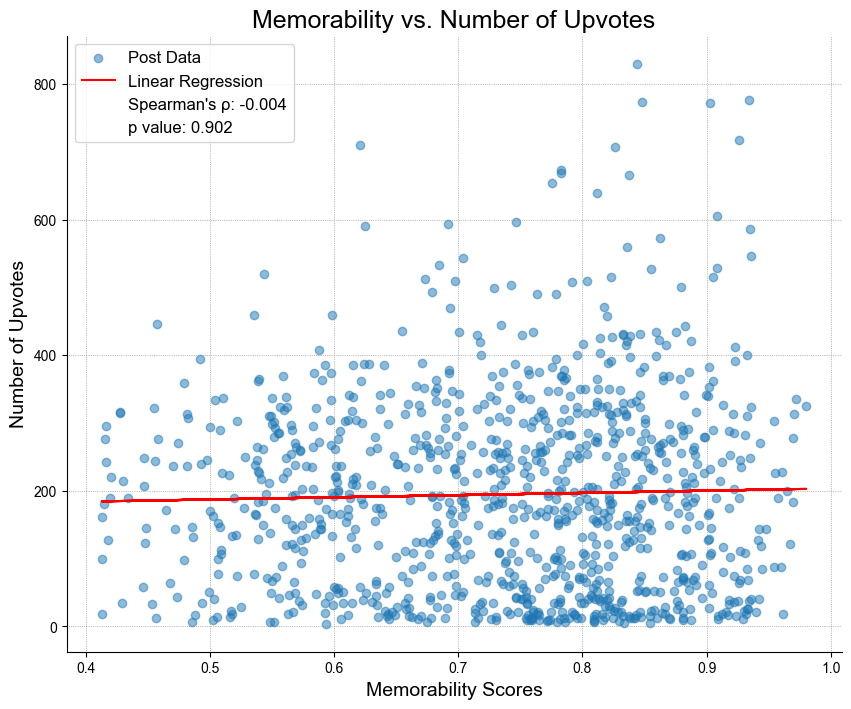

In [29]:
# Generate predictions
predictions = nb_model.predict(X_const)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(X, y, alpha=0.5, label='Post Data')
plt.plot(X, predictions, color='red', label='Linear Regression', linewidth=1.5)
legend_text = [f"Spearman's ρ: {spearman_upvotes[0]:.3f}", f'p value: {spearman_upvotes[1]:.3f}']
# Add the custom text to the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([plt.Line2D([], [], color='none', label=legend_text[0]), 
                plt.Line2D([], [], color='none', label=legend_text[1])])
plt.legend(handles=handles, fontsize=12)

plt.title('Memorability vs. Number of Upvotes', fontsize=18)
plt.xlabel('Memorability Scores', fontsize=14)
plt.ylabel('Number of Upvotes', fontsize=14)
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)    # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
plt.grid(True, linestyle=':', color='gray', linewidth=0.5)
plt.show()

In [30]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to parse the JSON strings
def parse_json(json_str):
    try:
        return ast.literal_eval(json_str)
    except ValueError as e:
        print(f"Error parsing JSON: {e}")

# Apply the function to each entry in the 'top_comments' column
df.loc[:, 'top_comments'] = df['top_comments'].apply(parse_json)

df['sentiment_scores'] = df['top_comments'].apply(
    lambda comments: [sia.polarity_scores(comment['comment_body'])['compound'] for comment in comments if 'comment_body' in comment]
)

df.loc[:,'average_sentiment'] = df['sentiment_scores'].apply(lambda scores: sum(scores) / len(scores) if scores else 0)
spearman_sentiments = spearmanr(df['memorability_score'], df['average_sentiment'])

print(f"Spearman rho: {spearman_sentiments[0].round(3)}")
print(f"p value: {spearman_sentiments[1].round(8)}")

Spearman rho: -0.242
p value: 0.0


In [31]:
X = df['memorability_score'].values.reshape(-1, 1)  # reshaping for sklearn
y = df['average_sentiment'].values
model = LinearRegression().fit(X, y)
predictions = model.predict(X)


In [32]:
sentiments = df[['id', 'average_sentiment']]

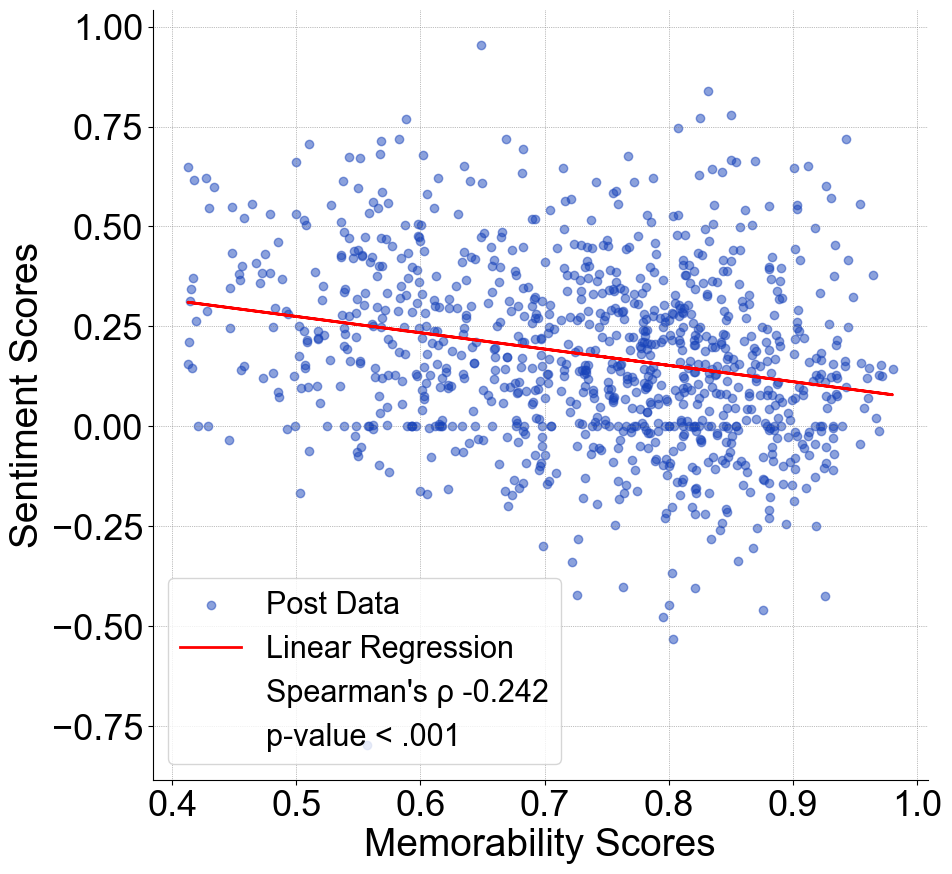

In [33]:
import matplotlib as mpl
mpl.rcParams['font.family']    = 'serif'
mpl.rcParams['font.serif']     = ['Arial']
# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(X, y, alpha=0.5, label='Post Data', color = '#1944ba')
plt.plot(X, predictions, color='red', label='Linear Regression', linewidth = 2)
legend_text = [f"Spearman's ρ {spearman_sentiments[0]:.3f}", f'p-value < .001']
# Add the custom text to the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([plt.Line2D([], [], color='none', label=legend_text[0]), 
                plt.Line2D([], [], color='none', label=legend_text[1])])
plt.legend(handles=handles, fontsize=22)

plt.xlabel('Memorability Scores', fontsize=28)
plt.ylabel('Sentiment Scores', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='both', which='minor', labelsize=26)
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)    # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
plt.grid(True, linestyle=':', color='gray', linewidth=0.5)
plt.show()

In [34]:
import scipy.stats as stats
import pandas as pd

bins = pd.qcut(df['memorability_score'], q=2, labels=['Low', 'High'])
df['memorability_bin'] = bins

low_group = df[df['memorability_bin'] == 'Low']['average_sentiment']
high_group = df[df['memorability_bin'] == 'High']['average_sentiment']
print(low_group.mean())
print(high_group.mean())

t_stat, p_val = stats.ttest_ind(high_group, low_group, alternative='less')
print(f"One-tailed T-test: t-statistic = {t_stat}, p-value = {p_val}")


0.22242317969271877
0.13469754016064256
One-tailed T-test: t-statistic = -6.332386351154634, p-value = 1.824204217962247e-10


In [35]:
import numpy as np
from scipy.stats import spearmanr

df['abs_sentiment'] = np.abs(df['average_sentiment'])
correlation, p_value = spearmanr(df['abs_sentiment'], df['memorability_score'])

print(f"Correlation: {correlation}, p-value: {p_value}")


Correlation: -0.18914938813589594, p-value: 1.7509230084726296e-09


## For each subreddit

### without removal

In [36]:
# data1 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data1/reddit_scores.csv')
# data2 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data2/reddit_scores.csv')
# data3 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data3/reddit_scores.csv')

# df = pd.concat([data1, data2, data3], ignore_index=True)

In [37]:
df_subs = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/alldata_final.csv')

In [38]:
subs = ['pic', 'pics', 'Images']
for sub in subs:
    df_sub = df_subs[df_subs['subreddit'].str.lower() == sub.lower()]
    print(f"{sub}:", df_sub.shape)


pic: (288, 13)
pics: (591, 13)
Images: (368, 13)


In [39]:
for sub in subs:
    print(f'\n subreddit: {sub}')
    df_sub  = df_subs[df_subs['subreddit'].str.contains(rf'{sub}',  case=False, na=False)]
    spearman_comments_sub = scipy.stats.spearmanr(df_sub['memorability_score'], df_sub['comments'])
    spearman_upvotes_sub = scipy.stats.spearmanr(df_sub['memorability_score'], df_sub['upvotes'])

    print('Memorability ~ Comments:',
      '\n', f'Spearman rho: {spearman_comments_sub[0].round(3)}',
      '\n', f'p value: {spearman_comments_sub[1].round(5)}')
    print('Memorability ~ upvotes:',
      '\n', f'Spearman rho: {spearman_upvotes_sub[0].round(3)}',
      '\n', f'p value: {spearman_upvotes_sub[1].round(3)}')




 subreddit: pic
Memorability ~ Comments: 
 Spearman rho: 0.307 
 p value: 0.0
Memorability ~ upvotes: 
 Spearman rho: 0.091 
 p value: 0.007

 subreddit: pics
Memorability ~ Comments: 
 Spearman rho: 0.128 
 p value: 0.0019
Memorability ~ upvotes: 
 Spearman rho: 0.076 
 p value: 0.065

 subreddit: Images
Memorability ~ Comments: 
 Spearman rho: 0.137 
 p value: 0.00871
Memorability ~ upvotes: 
 Spearman rho: 0.036 
 p value: 0.486


#### With outlier removal

In [40]:
for sub in subs:
    print(f'\n subreddit: {sub}')
    raw = df_subs[df_subs['subreddit'].str.contains(rf'{sub}',  case=False, na=False)]
    # Calculate Q1, Q3, and IQR for 'upvotes'
    Q1_upvotes = raw['upvotes'].quantile(0.25)
    Q3_upvotes = raw['upvotes'].quantile(0.75)
    IQR_upvotes = Q3_upvotes - Q1_upvotes

    # Calculate Q1, Q3, and IQR for 'comments'
    Q1_comments = raw['comments'].quantile(0.25)
    Q3_comments = raw['comments'].quantile(0.75)
    IQR_comments = Q3_comments - Q1_comments

    # Determine outliers' thresholds for 'upvotes'
    lower_thresh_upvotes = Q1_upvotes - 1.5 * IQR_upvotes
    upper_thresh_upvotes = Q3_upvotes + 1.5 * IQR_upvotes

    # Determine outliers' thresholds for 'comments'
    lower_thresh_comments = Q1_comments - 1.5 * IQR_comments
    upper_thresh_comments = Q3_comments + 1.5 * IQR_comments

    # outlier indices
    outlier_indices = raw[(raw['upvotes'] < lower_thresh_upvotes) | (raw['upvotes'] > upper_thresh_upvotes) |
                        (raw['comments'] < lower_thresh_comments) | (raw['comments'] > upper_thresh_comments)].index

    # Filter out outliers for both 'upvotes' and 'comments'
    df = raw.drop(outlier_indices).reset_index(drop=True)
    spearman_comments = scipy.stats.spearmanr(df['memorability_score'], df['comments'])
    spearman_upvotes = scipy.stats.spearmanr(df['memorability_score'], df['upvotes'])

    print('Memorability ~ Comments:',
        '\n', f'Spearman rho: {spearman_comments[0].round(3)}',
        '\n', f'p value: {spearman_comments[1].round(5)}')

    print('Memorability ~ upvotes:',
        '\n', f'Spearman rho: {spearman_upvotes[0].round(3)}',
        '\n', f'p value: {spearman_upvotes[1].round(5)}')
    


 subreddit: pic
Memorability ~ Comments: 
 Spearman rho: 0.261 
 p value: 0.0
Memorability ~ upvotes: 
 Spearman rho: -0.078 
 p value: 0.0418

 subreddit: pics
Memorability ~ Comments: 
 Spearman rho: 0.132 
 p value: 0.00361
Memorability ~ upvotes: 
 Spearman rho: 0.047 
 p value: 0.29865

 subreddit: Images
Memorability ~ Comments: 
 Spearman rho: 0.044 
 p value: 0.42489
Memorability ~ upvotes: 
 Spearman rho: -0.034 
 p value: 0.53172


### covariates

In [41]:
from PIL import Image
import os

def get_image_info(path):
    """
    Returns:
        - file size in KB (float)
        - resolution as total pixels (int)
    """
    file_size_kb = None
    resolution = None

    try:
        # Get file size in KB
        file_size_kb = os.path.getsize(path) / 1024
    except OSError:
        file_size_kb = None

    try:
        # Get width × height
        with Image.open(path) as img:
            width, height = img.size
            resolution = width * height
    except Exception:
        resolution = None

    return file_size_kb, resolution


results = df_subs['file_path'].apply(get_image_info)
df_subs['file_size_kb'], df_subs['resolution'] = zip(*results)
df_subs['file_size_kb'] = df_subs['file_size_kb'].round(1)

# Check first few rows
print(df_subs[['file_path', 'file_size_kb', 'resolution']].head())


                                           file_path  file_size_kb  resolution
0  /Users/lucian/Library/CloudStorage/Box-Box/mem...        3942.1    12000000
1  /Users/lucian/Library/CloudStorage/Box-Box/mem...        1858.9    12192768
2  /Users/lucian/Library/CloudStorage/Box-Box/mem...        1558.3      938520
3  /Users/lucian/Library/CloudStorage/Box-Box/mem...        1266.3      792800
4  /Users/lucian/Library/CloudStorage/Box-Box/mem...         170.3      874800


In [42]:
df_subs['date_posted'] = pd.to_datetime(df_subs['date_posted'])
# Extract hour of day
df_subs['hour_posted'] = df_subs['date_posted'].dt.hour

# Map to day (1) or night (0)
def map_day_night(hour):
    if 6 <= hour < 18:
        return 0
    else:
        return 1

df_subs['day_night'] = df_subs['hour_posted'].apply(map_day_night)


In [ ]:
data1 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data1/reddit_scores.csv')
data2 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data2/reddit_scores.csv')
data3 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data3/reddit_scores.csv')

# Define the scrape or observation date
data1['date_posted'] = pd.to_datetime(data1['date_posted'])
data2['date_posted'] = pd.to_datetime(data2['date_posted'])
data3['date_posted'] = pd.to_datetime(data3['date_posted'])
date_1 = pd.Timestamp("2024-04-19")
date_2 = pd.Timestamp("2024-04-26")
date_3 = pd.Timestamp("2024-05-21")

# Compute how long each post has been online
data1['days_online'] = (
    date_1 - data1['date_posted']
).dt.total_seconds() / (60 * 60 * 24)

data2['days_online'] = (
    date_2 - data1['date_posted']
).dt.total_seconds() / (60 * 60 * 24)

data3['days_online'] = (
    date_3 - data1['date_posted']
).dt.total_seconds() / (60 * 60 * 24)


all_data = pd.concat([data1,data2,data3]).reset_index(drop=False)
all_data['days_online'] = all_data['days_online'].clip(lower=0)
df_subs['days_since_start'] = all_data['days_online'] #no merge needed as all images are in the same order

In [ ]:
df_subs = pd.merge(df_subs, sentiments, how='inner')
df_numeric = df_subs[['memorability_score', 'comments', 'average_sentiment', 'caption_length', 'day_night', 'days_since_start', 'file_size_kb',  'resolution']]

corr= df_numeric.corr(method='spearman')
print(corr)


                    memorability_score  comments  average_sentiment  \
memorability_score            1.000000  0.202883          -0.242394   
comments                      0.202883  1.000000          -0.104798   
average_sentiment            -0.242394 -0.104798           1.000000   
caption_length                0.159449  0.180333          -0.061795   
day_night                    -0.003282 -0.002059           0.010861   
days_since_start             -0.039948 -0.066966           0.019570   
file_size_kb                 -0.199281 -0.094536           0.179507   
resolution                   -0.248371 -0.156273           0.202022   

                    caption_length  day_night  days_since_start  file_size_kb  \
memorability_score        0.159449  -0.003282         -0.039948     -0.199281   
comments                  0.180333  -0.002059         -0.066966     -0.094536   
average_sentiment        -0.061795   0.010861          0.019570      0.179507   
caption_length            1.000000  

In [45]:
import pandas as pd
from scipy.stats import spearmanr

# Create empty DataFrames for correlation coefficients and p-values
columns = df_numeric.columns
corr_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)
pval_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

# Compute pairwise Spearman correlations and p-values
for col1 in columns:
    for col2 in columns:
        corrval, pval = spearmanr(df_numeric[col1], df_numeric[col2], nan_policy='omit')
        corr_matrix.loc[col1, col2] = corrval
        pval_matrix.loc[col1, col2] = pval


In [46]:
df_subs.to_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/allData_covariates.csv')

In [ ]:
import plotly.express as px

x_labels = [
    "Memorability Score",
    "Comments",
    "Averaged Sentiment",
    "Caption Length",
    "Time of Day",
    "Posted Duration",
    "File Size",
    "Resolution",
]
y_labels = [
    "Memorability Score",
    "Comments",
    "Averaged Sentiment",
    "Caption Length",
    "Time of Day",
    "Posted Duration",
    "File Size",
    "Resolution",
]
color_scale = [
    [0.0, '#1944ba'],    # deep blue
    [0.5, '#e0e0e0'],    # light grey (instead of white)
    [1.0, 'red']     # strong red
]
fig = px.imshow(
    corr.values,
    x=list(range(len(x_labels))),
    y=list(range(len(y_labels))),
    color_continuous_scale=color_scale,
    zmin=-1,
    zmax=1,
    aspect='equal',
    text_auto='.2f',
    origin='lower'
)


fig.update_xaxes(
    tickmode='array',
    tickvals=list(range(len(x_labels))),
    ticktext=x_labels,
    tickangle=30,
    tickfont=dict(size=22),
    automargin=True,
    title="" 
)
fig.update_yaxes(
    tickmode='array',
    tickvals=list(range(len(y_labels))),
    ticktext=y_labels,
    autorange='reversed',
    tickfont=dict(size=22),
    automargin=True,
    title="" 
)
fig.update_yaxes(
    ticklabelposition='outside',
    tickfont=dict(size=22),
    automargin=True,
    title='',
    ticklabeloverflow='allow',
    tickson='boundaries',
    ticklabelstep=1,
    ticklabelstandoff=10
)
fig.update_layout(
    template='plotly_white',
    width=1000,
    height=900,
    margin=dict(l=120, r=120, t=100, b=120)
)


fig.update_traces(
    textfont=dict(size=18, color='white')   
)
fig.update_layout(
    font=dict(family='Arial'),
    coloraxis_colorbar=dict(
        tickfont=dict(size=20, color='black'),
        title=dict(text='Spearman Rho', side='right'),
        lenmode='fraction',
        len=0.9,
        thickness=20
    )
)
fig.show()


In [89]:
df = raw
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# predictors (caption length + time variable)
# X = df[['caption_length']]
X = df[['caption_length', 'resolution']]
comments = df['comments']
memorability = df['memorability_score']
# Regress comments on both confounds
reg_comments = LinearRegression()
reg_comments.fit(X, comments)
comments_residuals = comments - reg_comments.predict(X)

# Regress memorability on both confounds
reg_memorability = LinearRegression()
reg_memorability.fit(X, memorability)
memorability_residuals = memorability - reg_memorability.predict(X)

# Compute partial correlation
partial_corr, p_value = spearmanr(comments_residuals, memorability_residuals)

print(f"Partial correlation between memorability and comments (controlling for caption length): {partial_corr}")
print(f"P-value: {p_value}")

Partial correlation between memorability and comments (controlling for caption length): 0.14708751474423076
P-value: 3.102784276002069e-06


In [82]:
# predictors (caption length + time variable)
X = df[['file_size_kb', 'resolution']]
sentiment = df['average_sentiment']
memorability = df['memorability_score']
# Regress comments on both confounds
reg_sentiment = LinearRegression()
reg_sentiment.fit(X, sentiment)
sentiment_residuals = sentiment - reg_sentiment.predict(X)

# Regress memorability on both confounds
reg_memorability = LinearRegression()
reg_memorability.fit(X, memorability)
memorability_residuals = memorability - reg_memorability.predict(X)

# Compute partial correlation
partial_corr, p_value = spearmanr(sentiment_residuals, memorability_residuals)

print(f"Partial correlation between memorability and sentiment (controlling for covariates): {partial_corr}")
print(f"P-value: {p_value}")

Partial correlation between memorability and sentiment (controlling for covariates): -0.21717529275926525
P-value: 4.1590757301056944e-12


In [77]:
raw = df_subs
# Calculate Q1, Q3, and IQR for 'upvotes'
Q1_upvotes = raw['upvotes'].quantile(0.25)
Q3_upvotes = raw['upvotes'].quantile(0.75)
IQR_upvotes = Q3_upvotes - Q1_upvotes

# Calculate Q1, Q3, and IQR for 'comments'
Q1_comments = raw['comments'].quantile(0.25)
Q3_comments = raw['comments'].quantile(0.75)
IQR_comments = Q3_comments - Q1_comments

# Determine outliers' thresholds for 'upvotes'
lower_thresh_upvotes = Q1_upvotes - 1.5 * IQR_upvotes
upper_thresh_upvotes = Q3_upvotes + 1.5 * IQR_upvotes

# Determine outliers' thresholds for 'comments'
lower_thresh_comments = Q1_comments - 1.5 * IQR_comments
upper_thresh_comments = Q3_comments + 1.5 * IQR_comments

# outlier indices
outlier_indices = raw[(raw['upvotes'] < lower_thresh_upvotes) | (raw['upvotes'] > upper_thresh_upvotes) |
                      (raw['comments'] < lower_thresh_comments) | (raw['comments'] > upper_thresh_comments)].index

# Filter out outliers for both 'upvotes' and 'comments'
df = raw.drop(outlier_indices).reset_index(drop=True)

In [78]:
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# predictors (caption length + time variable)
# X = df[['caption_length']]
X = df[['caption_length', 'resolution']]
comments = df['comments']
memorability = df['memorability_score']
# Regress comments on both confounds
reg_comments = LinearRegression()
reg_comments.fit(X, comments)
comments_residuals = comments - reg_comments.predict(X)

# Regress memorability on both confounds
reg_memorability = LinearRegression()
reg_memorability.fit(X, memorability)
memorability_residuals = memorability - reg_memorability.predict(X)

# Compute partial correlation
partial_corr, p_value = spearmanr(comments_residuals, memorability_residuals)

print(f"Partial correlation between memorability and comments (controlling for caption length): {partial_corr}")
print(f"P-value: {p_value}")


Partial correlation between memorability and comments (controlling for caption length): 0.12028018553367263
P-value: 0.0002762391365992791


In [79]:
# predictors (caption length + time variable)
X = df[['file_size_kb', 'resolution']]
sentiment = df['average_sentiment']
memorability = df['memorability_score']
# Regress comments on both confounds
reg_sentiment = LinearRegression()
reg_sentiment.fit(X, sentiment)
sentiment_residuals = sentiment - reg_sentiment.predict(X)

# Regress memorability on both confounds
reg_memorability = LinearRegression()
reg_memorability.fit(X, memorability)
memorability_residuals = memorability - reg_memorability.predict(X)

# Compute partial correlation
partial_corr, p_value = spearmanr(sentiment_residuals, memorability_residuals)

print(f"Partial correlation between memorability and sentiment (controlling for caption length): {partial_corr}")
print(f"P-value: {p_value}")

Partial correlation between memorability and sentiment (controlling for caption length): -0.23697549159775955
P-value: 4.4137041573869064e-13


In [50]:
df_subs = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/allData_covariates.csv')

In [51]:
summary_table = df_subs.describe()